# Primary Modelling

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data_with_dists.csv', sep=';')

In [3]:
percentile_82 = np.percentile(df['price'], 82)
print(percentile_82)

5900000.0


In [4]:
df = df.drop('street', axis=1)
df = df[df['price'] < percentile_82]

In [5]:
df.index = range(len(df))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number of rooms       925 non-null    int64  
 1   area of apartment     925 non-null    float64
 2   number of floors      925 non-null    int64  
 3   apartment floor       925 non-null    int64  
 4   price                 925 non-null    float64
 5   repair                925 non-null    object 
 6   bathroom              925 non-null    object 
 7   terrace               925 non-null    object 
 8   year of construction  925 non-null    int64  
 9   elevator              925 non-null    int64  
 10  garbage chute         925 non-null    int64  
 11  type of house         925 non-null    object 
 12  district              925 non-null    object 
 13  concierge             925 non-null    int64  
 14  distance              925 non-null    float64
dtypes: float64(3), int64(7)

## Подготовка категориальных признаков

### Разбиение на данные и целевую метку

In [7]:
not_categorial_features = []
for column in df.columns:
    if df[column].dtype != 'object':
        not_categorial_features.append(column)

In [8]:
data = df[not_categorial_features].copy()

### One-Hot-кодирование для категориальных признаков

In [9]:
from sklearn.preprocessing import OneHotEncoder

def get_one_hot_df(df, column):
    encoder = OneHotEncoder()
    new_df = pd.DataFrame(encoder.fit_transform(df[[column]]).toarray())
    new_df.columns = [column + '_' + feature[3:] for feature in encoder.get_feature_names()]
    return new_df

In [10]:
for column in df.columns:
    if df[column].dtype == 'object':
        one_hot_df = get_one_hot_df(df, column)
        data = pd.merge(data, one_hot_df, left_index=True, right_index=True)

In [11]:
target = data[['price']].copy()
data = data.drop('price', axis=1)

### Результат

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   number of rooms                 925 non-null    int64  
 1   area of apartment               925 non-null    float64
 2   number of floors                925 non-null    int64  
 3   apartment floor                 925 non-null    int64  
 4   year of construction            925 non-null    int64  
 5   elevator                        925 non-null    int64  
 6   garbage chute                   925 non-null    int64  
 7   concierge                       925 non-null    int64  
 8   distance                        925 non-null    float64
 9   repair_дизайнерский             925 non-null    float64
 10  repair_евро                     925 non-null    float64
 11  repair_косметический            925 non-null    float64
 12  repair_требует ремонта          925 

## Деление на тестовую и тренировочную выборки

In [13]:
X = data.values
y = target.values

In [14]:
X.shape, y.shape

((925, 30), (925, 1))

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=42)

## Нормализация количественных данных

In [16]:
not_categorial_features.remove('price')

In [17]:
from sklearn.preprocessing import StandardScaler

scalers = []
for index in range(len(not_categorial_features)):
    scaler = StandardScaler()
    X_train[:, index] = scaler.fit_transform(X_train[:, index].reshape(-1, 1)).reshape(-1)
    scalers.append(scaler)

In [18]:
y_train = y_train / 1_000_000

### Подготовка тестовых данных

In [19]:
for index in range(len(not_categorial_features)):
    scaler = scalers[index]
    X_test[:, index] = scaler.transform(X_test[:, index].reshape(-1, 1)).reshape(-1)

In [20]:
y_test = y_test / 1_000_000

# Модели

In [21]:
X_train[0, :]

array([-0.02133779,  0.26605209,  0.9901912 , -1.10827025,  0.57220584,
        0.25674481,  1.11464086,  1.64881562, -0.58184552,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ])

In [22]:
y_train[0]

array([3.39])

## Простая линейная модель

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
simple_reg = LinearRegression().fit(X_train, y_train)

In [25]:
simple_reg.coef_, simple_reg.intercept_

(array([[-0.01893108,  0.78223868,  0.12844978,  0.01726845,  0.22693237,
         -0.0078642 , -0.05414561, -0.00870975, -0.27312156,  0.18903533,
          0.14656526, -0.11780992, -0.21779067, -0.35486792,  0.16828958,
          0.18657834,  0.0281596 ,  0.15417228, -0.18233188, -0.21283854,
          0.09079763,  0.04710159,  0.07493933,  0.08002661,  0.15636198,
         -0.03105346,  0.47779837, -0.10012407, -0.52434698, -0.05866245]]),
 array([3.23530801]))

In [26]:
predicts = simple_reg.predict(X_test)

mse = mean_squared_error(y_test, predicts)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.446


## Простая линейная модель без смещения

In [27]:
simple_reg_without_intercept = LinearRegression(fit_intercept=False).fit(X_train, y_train)

In [28]:
simple_reg_without_intercept.coef_, simple_reg_without_intercept.intercept_, 

(array([[-0.01893108,  0.78223868,  0.12844978,  0.01726845,  0.22693237,
         -0.0078642 , -0.05414561, -0.00870975, -0.27312156,  0.80668504,
          0.76421497,  0.49983979,  0.39985904,  0.46866503,  0.99182253,
          1.01011128,  0.85169255,  0.97770523,  0.64120107,  0.40481117,
          0.70844734,  0.6647513 ,  0.69258904,  0.4329693 ,  0.50930467,
          0.32188923,  0.83074106,  0.25281862, -0.17140429,  0.29428024]]),
 0.0)

In [29]:
predicts = simple_reg_without_intercept.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.446


## Простая линейная модель без смещения c регуляризацией

In [30]:
from sklearn.linear_model import Ridge

In [31]:
best_alpha = 15
simple_ridge = Ridge(alpha=best_alpha, fit_intercept=False).fit(X_train, y_train)
simple_ridge.coef_, simple_ridge.intercept_

(array([[-4.60511911e-04,  7.66566688e-01,  1.36855184e-01,
          1.45528031e-02,  2.30393518e-01,  2.26975904e-03,
         -6.29350662e-02, -8.02056923e-03, -2.94691418e-01,
          6.10820206e-01,  7.24472199e-01,  5.22723991e-01,
          3.87703457e-01,  2.10898971e-01,  9.96440584e-01,
          1.03838030e+00,  7.76084782e-01,  9.32803311e-01,
          5.36831758e-01,  1.70426170e-01,  7.60587521e-01,
          5.99987041e-01,  7.14719119e-01,  4.13076021e-01,
          4.71576131e-01,  3.49692733e-01,  5.63361057e-01,
          2.49690517e-01, -8.57195800e-02,  2.84042972e-01]]),
 0.0)

In [32]:
predicts = simple_ridge.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.46


## Случайный лес

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
rf_reg =  RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train.ravel()) 

RandomForestRegressor(random_state=42)

In [35]:
predicts = rf_reg.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.416


In [36]:
pd.DataFrame({'feature': data.columns, 'importance': rf_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,area of apartment,0.547325
8,distance,0.163523
4,year of construction,0.156447
2,number of floors,0.030872
28,district_р-н Орджоникидзевский,0.015317
3,apartment floor,0.014959
17,terrace_лоджия,0.006108
24,district_р-н Индустриальный,0.005790
0,number of rooms,0.005165
21,type of house_монолитный,0.004835


## AdaBoost

In [37]:
from sklearn.ensemble import AdaBoostRegressor

In [38]:
ada_reg = AdaBoostRegressor(random_state=42)
ada_reg.fit(X_train, y_train.ravel()) 

AdaBoostRegressor(random_state=42)

In [39]:
predicts = ada_reg.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.514


In [40]:
pd.DataFrame({'feature': data.columns, 'importance': ada_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,area of apartment,0.508992
4,year of construction,0.138771
8,distance,0.135276
2,number of floors,0.054856
28,district_р-н Орджоникидзевский,0.046433
3,apartment floor,0.030794
9,repair_дизайнерский,0.014125
24,district_р-н Индустриальный,0.011320
12,repair_требует ремонта,0.011154
7,concierge,0.009627


## Градиентный бустинг

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

In [42]:
grad_reg = GradientBoostingRegressor(random_state=42)
grad_reg.fit(X_train, y_train.ravel()) 

GradientBoostingRegressor(random_state=42)

In [43]:
predicts = grad_reg.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.393


In [44]:
pd.DataFrame({'feature': data.columns, 'importance': grad_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,area of apartment,0.573430
8,distance,0.165865
4,year of construction,0.158042
2,number of floors,0.031194
28,district_р-н Орджоникидзевский,0.022508
17,terrace_лоджия,0.008089
3,apartment floor,0.006374
10,repair_евро,0.004470
12,repair_требует ремонта,0.004322
18,terrace_нет,0.004190


## Бэггинг

In [45]:
from sklearn.ensemble import BaggingRegressor

In [46]:
bag_reg = BaggingRegressor(random_state=42)
bag_reg.fit(X_train, y_train.ravel()) 

BaggingRegressor(random_state=42)

In [47]:
predicts = bag_reg.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.422


## XGBoost

In [48]:
import xgboost as xgb

In [49]:
xgb_reg = xgb.XGBRegressor(n_estimators=150, learning_rate=0.05,
                          max_depth=6, random_state=42) 
xgb_reg.fit(X_train, y_train.ravel()) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
predicts = xgb_reg.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  0.382


In [51]:
pd.DataFrame({'feature': data.columns, 'importance': xgb_reg.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,area of apartment,0.325777
4,year of construction,0.111995
28,district_р-н Орджоникидзевский,0.077828
8,distance,0.068955
2,number of floors,0.041259
7,concierge,0.034782
26,district_р-н Ленинский,0.029877
17,terrace_лоджия,0.025422
24,district_р-н Индустриальный,0.025332
27,district_р-н Мотовилихинский,0.023716


## XGBoost на нестандартизированных данных

In [52]:
X = data.values
y = target.values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, 
                                                    random_state=42)

In [53]:
xgb_reg = xgb.XGBRegressor(n_estimators=150, learning_rate=0.05,
                          max_depth=6) 
xgb_reg.fit(X_train, y_train.ravel()) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
predicts = xgb_reg.predict(X_test)

mse = mean_squared_error(predicts, y_test)
rmse = np.sqrt(mse)
print("RMSE ", round(rmse, 3))

RMSE  388267.801


## Визуализация XGBoost

In [55]:
import matplotlib.pyplot as plt

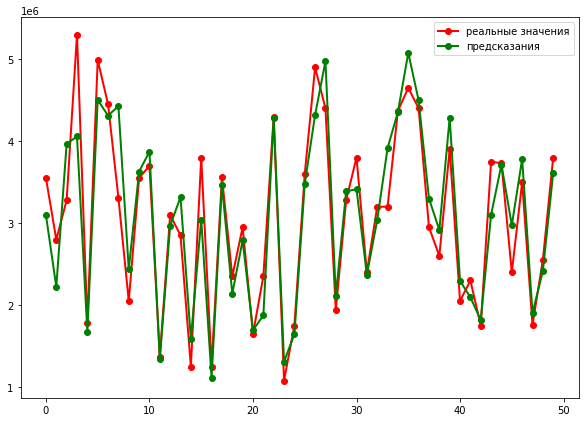

In [56]:
plt.figure(figsize=(10, 7))
plt.plot(y_test[:50], '-ro', linewidth=2, label='реальные значения')
plt.plot(predicts[:50], '-go', linewidth=2, label='предсказания')
plt.legend()

Text(0, 0.5, 'Предсказанная цена')

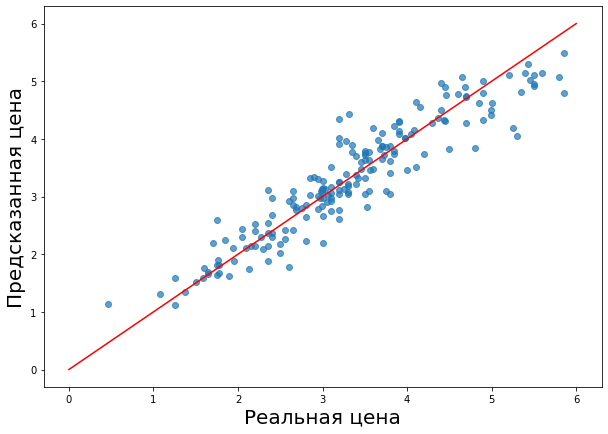

In [57]:
plt.figure(figsize=(10, 7))
plt.plot(np.array(range(7)), np.array(range(7)), c='r')
plt.scatter(y_test/1_000_000, predicts/1_000_000, alpha=0.7)
plt.xlabel("Реальная цена", size=20)
plt.ylabel("Предсказанная цена", size=20)

## Выводы

#### Дорогие квартиры
Модели плохо работают с квартирами, имеющими высокую цену (порядка 6 миллионов). Это можно интерпретировать как то, что такие квартиры не отличаются от квартир более низкой ценовой категории по характеристикам, поэтому модель не может сделать прогноз выше, иными словами, цены на эти квартиры сильно завышены.

В качестве решения можно было бы дополнить признаками собственности (частник или агенство), так как наличие агента увеличивает цену, новостроечности (да или нет), так как в новостройках квартиры стоят дороже, но это частично должно быть учтено в годе дома. 

#### Ключевые признаки
Модели, использующие решающие леса, показали наиболее важные признаки при решении задачи регрессии:
**Площадь**, **год постройки**, **расстояние до центра**, **количество этажей**

#### Предложение
Необходимо произвести анализ категориальных признаков и преобразовать их в количественные. Например, район можно преобразовать в соответствии с уровнем преступности или показателем благополучия.